##### Copyright 2021 The TensorFlow Probability Authors

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# SNAPER-HMC

This colab provides an implementation of the SNAPER criterion and Adaptive SGA-HMC from the [*Focusing on Difficult Directions for Learning HMC Trajectory  Lengths*](https://arxiv.org/abs/2110.11576) paper.

## Install Dependencies

In [0]:
!rm -Rf probability
!rm -Rf fun_mc
!rm -Rf inference_gym
!git clone --depth 1 https://github.com/tensorflow/probability.git
!mv probability/spinoffs/fun_mc/fun_mc .
!mv probability/spinoffs/inference_gym/inference_gym .
!pip install -U tf-nightly tfp-nightly jax jaxlib immutabledict

### Environment

In [0]:
!pip freeze

absl-py==0.12.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argcomplete==1.12.3
argon2-cffi==21.1.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.2.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.10
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.5.1.1
chardet==3.0.4
charset-normalizer==2.0.7
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==2.0.6
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda111==9.4.0
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.24
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.4


## Imports

In [0]:
import functools
import fun_mc.using_jax as fun_mc
import tensorflow_probability.substrates.jax as tfp
import jax
import jax.numpy as jnp
from jax import lax
import matplotlib.pyplot as plt
import inference_gym.using_jax as gym
from typing import Any, NamedTuple

## SNAPER criterion

In [0]:
def power_iteration(sample, r, steps=4):
  r = r / (1e-20 + jnp.linalg.norm(r))
  for i in range(steps):
    r = (jnp.einsum('d,nd->n', r, sample)[:, jnp.newaxis] * sample).sum(0)
    r = r / (1e-20 + jnp.linalg.norm(r))
  return r

def snaper_criterion(
    previous_state,
    proposed_state,
    accept_prob,
    trajectory_length,
    power = 1.,
    state_mean = None,
    state_mean_weight = 0.,
    p=None,
):
  batch_ndims = len(accept_prob.shape)
  batch_axes = tuple(range(batch_ndims))

  no_state_mean = object()
  if state_mean is None:
    state_mean = fun_mc.maybe_broadcast_structure(no_state_mean, previous_state)
  state_mean_weight = fun_mc.maybe_broadcast_structure(state_mean_weight,
                                                       previous_state)
  mx = state_mean
  mw = state_mean_weight

  x_center = previous_state.mean(0)
  if mx is not no_state_mean:
    x_center = x_center * (1 - mw) + mx * mw
  previous_state = previous_state - x_center

  x = proposed_state
  expand_shape = list(accept_prob.shape) + [1] * (
      len(x.shape) - len(accept_prob.shape))
  expanded_accept_prob = jnp.reshape(accept_prob, expand_shape)

  x_safe = jnp.where(jnp.isfinite(x), x, jnp.zeros_like(x))
  # If all accept_prob's are zero, the x_center will have a nonsense value,
  # but we'll set the overall criterion to zero in this case, so it's fine.
  x_center = (
      jnp.sum(
          expanded_accept_prob * x_safe,
          axis=batch_axes,
      ) / (jnp.sum(expanded_accept_prob, axis=batch_axes) + 1e-20))
  if mx is not no_state_mean:
    x_center = x_center * (1 - mw) + mx * mw
  proposed_state = x - lax.stop_gradient(x_center)

  if p is None:
    p = lax.stop_gradient(
        power_iteration(previous_state, previous_state[0], 10))
  
  previous_state = jnp.einsum('d,nd->n', p, previous_state)
  proposed_state = jnp.einsum('d,nd->n', p, proposed_state)

  esjd = ((previous_state**2 - proposed_state**2)**2)

  esjd = jnp.where(accept_prob > 1e-4, esjd, 0.)
  accept_prob = accept_prob / jnp.sum(accept_prob + 1e-20)
  esjd = esjd * accept_prob

  return esjd.mean() / trajectory_length**power, ()

## Adaptive SGA-HMC

In [0]:
def _halton(float_index, max_bits=10):
  float_index = jnp.asarray(float_index)
  bit_masks = 2**jnp.arange(max_bits, dtype=float_index.dtype)
  return jnp.einsum('i,i->', jnp.mod((float_index + 1) // bit_masks, 2),
                    0.5 / bit_masks)


def fixed_trajectory_length_sample(trajectory_length_params,
                                   step,
                                   seed,
                                   max_norm=100000.):
  del seed
  mean_trajectory_length = jnp.exp(
      fun_mc.clip_grads(trajectory_length_params.log_mean_trajectory_length,
                        max_norm))
  trajectory_length = 2 * _halton(
      jnp.array(step, mean_trajectory_length.dtype)) * mean_trajectory_length
  return trajectory_length


class AdaptiveSGAHMCState(NamedTuple):
  sga_hmc_state: fun_mc.prefab.StochasticGradientAscentHMCState
  rvar_state: fun_mc.RunningVarianceState
  principal_rmean_state: fun_mc.RunningMeanState
  ssa_state: fun_mc.prefab.StepSizeAdaptationState
  step: jnp.ndarray


class AdaptiveSGAHMCExtra(NamedTuple):
  sga_hmc_extra: fun_mc.prefab.StochasticGradientAscentHMCExtra
  scalar_step_size: jnp.ndarray
  step_size_scale: jnp.ndarray
  principal: jnp.ndarray


def adaptive_sga_hmc_init(state, target_log_prob_fn, init_step_size):
  sga_hmc_state = fun_mc.prefab.stochastic_gradient_ascent_hmc_init(
      state=state,
      target_log_prob_fn=target_log_prob_fn,
      init_trajectory_length=init_step_size)

  return AdaptiveSGAHMCState(
      sga_hmc_state=sga_hmc_state,
      principal_rmean_state=fun_mc.running_mean_init(state.shape[1:], state.dtype)._replace(
                  mean=jax.random.normal(jax.random.PRNGKey(0), state.shape[1:], state.dtype)),
      rvar_state=fun_mc.running_variance_init(state.shape[1:], state.dtype),
      ssa_state=fun_mc.prefab.step_size_adaptation_init(init_step_size),
      step=jnp.array(0, jnp.int32),
  )


def adaptive_sga_hmc_step(
    asga_hmc_state,
    num_mala_steps,
    num_adaptation_steps,
    seed,
    max_num_integrator_steps=500,
    rvar_factor=8,
    iterate_factor=16,
    principal_factor=8,
    criterion_fn=snaper_criterion,
    target_accept_prob=0.8,
    step_size_adaptation_rate=0.05,
    trajectory_length_adaptation_rate=0.05,
    **sga_hmc_kwargs,
):
  seed, hmc_seed = jax.random.split(seed)

  adapt = asga_hmc_state.step < num_adaptation_steps
  mala = asga_hmc_state.step < num_mala_steps
  num_chains = asga_hmc_state.sga_hmc_state.hmc_state.state.shape[0]

  step_size = asga_hmc_state.ssa_state.step_size(
      num_adaptation_steps=num_adaptation_steps)
  step_size_scale = jnp.sqrt(asga_hmc_state.rvar_state.variance)
  step_size_scale = step_size_scale / step_size_scale.max()

  principal_component = (asga_hmc_state.principal_rmean_state.mean /
               jnp.linalg.norm(asga_hmc_state.principal_rmean_state.mean))

  def trajectory_length_sample_fn(log_mean_trajectory_length, step, seed):
    hmc_trajectory = fixed_trajectory_length_sample(
        log_mean_trajectory_length, step=step, seed=seed)
    mala_trajectory = step_size
    return jnp.where(mala, mala_trajectory, hmc_trajectory)

  sga_hmc_state, sga_hmc_extra = fun_mc.prefab.stochastic_gradient_ascent_hmc_step(
      asga_hmc_state.sga_hmc_state,
      criterion_fn=functools.partial(
          criterion_fn,
          state_mean=asga_hmc_state.rvar_state.mean,
          state_mean_weight=(asga_hmc_state.rvar_state.num_points) / (
            asga_hmc_state.rvar_state.num_points + num_chains),
          p=principal_component,
      ),
      trajectory_length_sample_fn=trajectory_length_sample_fn,
      trajectory_length_constrain_fn=functools.partial(
          fun_mc.prefab.default_trajectory_length_constrain,
          max_trajectory_length=max_num_integrator_steps * step_size),
      scalar_step_size=step_size,
      step_size_scale=step_size_scale,
      adapt=adapt,
      averaging_window_steps=asga_hmc_state.step // iterate_factor,
      seed=hmc_seed,
      trajectory_length_adaptation_rate=trajectory_length_adaptation_rate,
      **sga_hmc_kwargs,
  )

  mean = sga_hmc_state.hmc_state.state.mean(0)

  cand_principal_rmean_state, _ = fun_mc.running_mean_step(
      asga_hmc_state.principal_rmean_state,
      power_iteration((sga_hmc_state.hmc_state.state -
                        mean),
                      asga_hmc_state.principal_rmean_state.mean, 1),
      window_size=asga_hmc_state.step // principal_factor,
  )

  principal_rmean_state = fun_mc.choose(
      adapt, cand_principal_rmean_state, asga_hmc_state.principal_rmean_state)

  ssa_state, _ = fun_mc.prefab.step_size_adaptation_step(
      asga_hmc_state.ssa_state,
      sga_hmc_extra.hmc_extra.log_accept_ratio,
      reduce_fn=tfp.math.reduce_log_harmonic_mean_exp,
      num_adaptation_steps=num_adaptation_steps,
      averaging_window_steps=asga_hmc_state.step // iterate_factor,
      adaptation_rate=step_size_adaptation_rate,
      adaptation_rate_decay_power=0.,
      target_accept_prob=target_accept_prob,
  )

  new_rvar_state, _ = fun_mc.running_variance_step(
      asga_hmc_state.rvar_state,
      sga_hmc_state.hmc_state.state,
      axis=tuple(
          range(len(asga_hmc_state.sga_hmc_state.hmc_state.target_log_prob.shape))),
      window_size=num_chains * asga_hmc_state.step // rvar_factor)
  rvar_state = fun_mc.choose(adapt, new_rvar_state, asga_hmc_state.rvar_state)

  asga_hmc_state = asga_hmc_state._replace(
      sga_hmc_state=sga_hmc_state,
      principal_rmean_state=principal_rmean_state,
      ssa_state=ssa_state,
      rvar_state=rvar_state,
      step=asga_hmc_state.step + 1,
  )
  asga_hmc_extra = AdaptiveSGAHMCExtra(
      sga_hmc_extra=sga_hmc_extra,
      scalar_step_size=step_size,
      step_size_scale=step_size_scale,
      principal=principal_component,
  )
  return asga_hmc_state, asga_hmc_extra

## Experiment

In [0]:
target = gym.targets.VectorModel(gym.targets.RadonContextualEffectsIndiana())

In [0]:
def target_log_prob_fn(x):
  return target.unnormalized_log_prob(x), ()


num_chains = 64
init_step_size = 1e-2
init_z = target.default_event_space_bijector.inverse(
    jnp.tile(
        target.structured_event_to_vector(
            target.model.prior_distribution().sample(
                256, seed=jax.random.PRNGKey(0))).mean(0, keepdims=True),
        [num_chains, 1]))
seed = jax.random.PRNGKey(3)
num_mala_steps = 100
num_adaptation_steps = 2000
num_results = 1000

target_log_prob_fn = fun_mc.transform_log_prob_fn(
    target_log_prob_fn, target.default_event_space_bijector)


def kernel(asga_hmc_state, seed):
  seed, hmc_seed = jax.random.split(seed)
  asga_hmc_state, asga_hmc_extra = adaptive_sga_hmc_step(
      asga_hmc_state,
      target_log_prob_fn=target_log_prob_fn,
      num_mala_steps=num_mala_steps,
      num_adaptation_steps=num_adaptation_steps,
      seed=seed)

  traced = dict(
      is_accepted=asga_hmc_extra.sga_hmc_extra.hmc_extra.is_accepted,
      z_chain=asga_hmc_state.sga_hmc_state.hmc_state.state,
      chain=asga_hmc_state.sga_hmc_state.hmc_state.state_extra[0],
      principal_component=asga_hmc_extra.principal,
      scalar_step_size=asga_hmc_extra.scalar_step_size,
      step_size_scale=asga_hmc_extra.step_size_scale,
      mean_trajectory_length=asga_hmc_extra.sga_hmc_extra
      .trajectory_length_params.mean_trajectory_length(),
      num_leapfrog_steps=asga_hmc_extra.sga_hmc_extra.num_integrator_steps)

  return (asga_hmc_state, seed), traced


out, traced = fun_mc.trace(
    (adaptive_sga_hmc_init(
        init_z,
        target_log_prob_fn=target_log_prob_fn,
        init_step_size=init_step_size), seed),
    kernel,
    num_adaptation_steps + num_results,
)

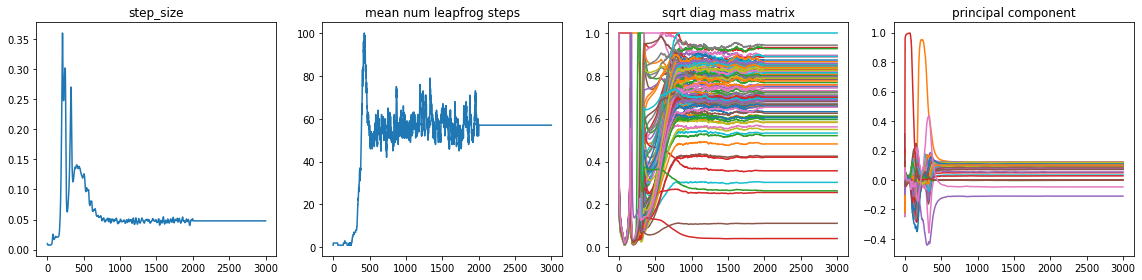

In [0]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

ax = axs[0]
ax.set_title('step_size')
ax.plot(traced['scalar_step_size'])

ax = axs[1]
ax.set_title('mean num leapfrog steps')
ax.plot(jnp.ceil(traced['mean_trajectory_length'] / traced['scalar_step_size']))

ax = axs[2]
ax.set_title('sqrt diag mass matrix')
ax.plot(traced['step_size_scale'])

ax = axs[3]
ax.set_title('principal component')
ax.plot(traced['principal_component'])

fig.tight_layout()

In [0]:
f = lambda x: jnp.square(x - x.mean((0, 1)))
warmed_up_z_chain = f(traced['z_chain'][num_adaptation_steps:])

print('Max R-hat', tfp.mcmc.potential_scale_reduction(warmed_up_z_chain).max())
print('Min ESS/grad', tfp.mcmc.effective_sample_size(warmed_up_z_chain,
                                                     cross_chain_dims=[1]).min() / num_chains / traced['num_leapfrog_steps'][num_adaptation_steps:].sum())

Max R-hat 1.0046246
Min ESS/grad 0.004120366
